# **Classification**

In [1]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

## Import MNIST Dataset

In [2]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(X.shape, y.shape)

(70000, 784) (70000,)


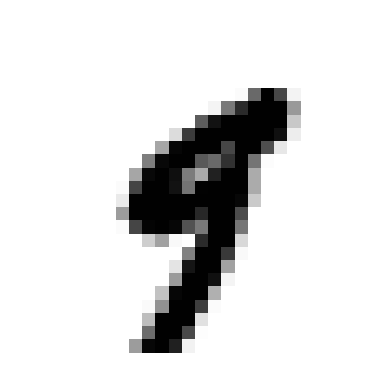

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def show_image(some_digit):
    some_digit_image = some_digit.reshape(28, 28)

    plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()

some_digit = X[36000]
show_image(some_digit)

In [4]:
y[36000]

'9'

## Split train test set

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#### Shuffle train since some learning algorithms are sensitive to the order of the training instances, and this will also guarantee that all cross-validation folds will be similar

In [6]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Try Training a Binary Classifier

The Binary Classification Problem is that model will be capable of distinguishing between **just 2 classes**, is or is not. 

In [7]:
y_train = y_train.astype(np.int8) # Ensure label is integer

y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) # SGDClassifier relies on randomness during training
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

[False]


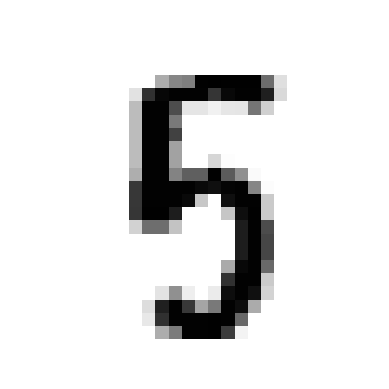

[ True]


In [9]:
print(sgd_clf.predict([some_digit])) # 9

for i in range(len(y_train_5)):
    if (y_train_5[i] == True):
        some_digit = X_train[i]
        show_image(some_digit)
        break

print(sgd_clf.predict([some_digit]))

## Performance Measures

### Measuring Accuracy Using Cross-Validation

Occasionally we will need more control over the cross-validation process than what Scikit-Learn provides off-the-shelf. So, let's try to implement cross-validation ourselves.

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)

    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    
    print(n_correct / len(y_pred))

0.95895
0.96075
0.96365


In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95895, 0.96075, 0.96365])

As we can see, they are the same.

Accuracy above 93% accuracy is quite amazing! However, let's look at our training set

In [12]:
not_5_train = (y_train_5 == False)
np.count_nonzero(not_5_train) / len(not_5_train)

0.90965

Above number shows that our training set has approximately 90% not 5. Show, if we always guess that an image is *not* a 5, we will be right about 90% of the time.x

### Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the *confusion matrix*.
The general idea is to count the number of times instances of class A are classified as class B, and transform it into a matrix.

In [13]:
# Init value
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # we can get clean prediction here

In [14]:
len(y_train_pred)

60000

In [15]:
# Build matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_train_5, y_train_pred)

matrix

array([[53178,  1401],
       [  932,  4489]], dtype=int64)

53894 (actual: 0 - predict: 0) -> true negative \
685 (actual: 0 - predict: 1) -> false positive \
2036 (actual: 1 - predict: 0) -> false negative \
3385 (actual: 1 - predict: 1) -> true positive 

**Precision** = TP / (TP + FP) \
**Recall** = TP / (TP + FN)

In [16]:
from sklearn.metrics import precision_score, recall_score

print("{} / ({} + {}) = {}".format(matrix[1][1], matrix[1][1], matrix[0][1], precision_score(y_train_5, y_train_pred)))
print("{} / ({} + {}) = {}".format(matrix[1][1], matrix[1][1], matrix[1][0], recall_score(y_train_5, y_train_pred)))

4489 / (4489 + 1401) = 0.7621392190152801
4489 / (4489 + 932) = 0.8280760007378712


Look at above numbers, we can see that: 
- When model claims an image represents a 5, it is correct only 71% of the time.
- And, model only detects 83% of the 5s. \

Sometimes, we will prefer higher Precision, and in other times, we will prefer a higher Recall. But we cannot have both, increasing precision reduces reall, and vice versa. This is called the *precision/recall tradeoff*

In [17]:
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.7937406064892583


### Precision/Recall Tradeoff

In [18]:
y_scores = sgd_clf.decision_function([some_digit]) 
# decision_function() returns a score for each instance, then makes predictions base on threshold
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

[5767.76831589]


array([ True])

In [19]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred   

array([False])

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                            method="decision_function")

In [21]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [22]:
thresholds

array([-142065.54200286, -141705.2374811 , -141525.21865381, ...,
         37206.51198547,   37485.80728321,   39734.38692023])

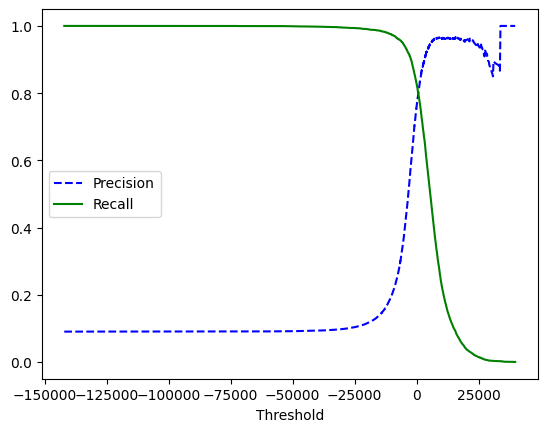

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(["Precision", "Recall"])
    plt.xlabel("Threshold")
    [...] # highlight the threshold, add the legend, axis label and grid

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Let's suppose we decide to aim for 90% precision. We look up the first plot and find that we need to use a threshold of about 8,000. But, to more precise we can search for the lowest threshold that gives us at least 90% precision(*np.argmax()*)

In [24]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision 

3176.707540503516

In [25]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.900176012069399
0.6603947611141856


### The ROC Curve

In [26]:
from sklearn.metrics import roc_curve 

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

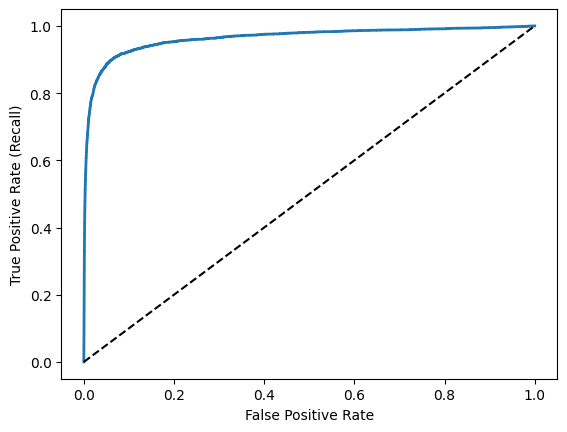

In [27]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dash diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.show()

In [28]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9640146222450983

In [29]:
from sklearn.ensemble import RandomForestClassifier 

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                    method="predict_proba")

In [30]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

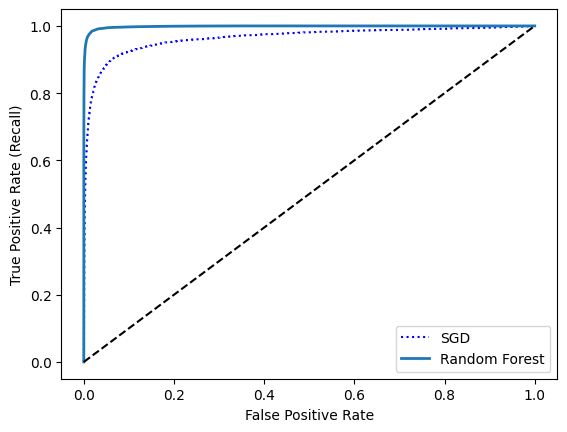

In [31]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

Which curve comes much closer to the top-left is the better

In [32]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984172909274152

## Multiclass Classification

In [33]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [34]:
sgd_clf.predict([some_digit])

array([5], dtype=int8)

Under the hood, Scikit-Learn actually trained 10 binary classifers, got their decision scores for the image, and selected the class with the highest score.

In [35]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-20695.42734443, -24740.61299602, -12164.55263665,
         -5295.52678977,  -4062.81026378,   3417.95805351,
        -26589.14412198, -15046.27027821,   1319.60525395,
         -9571.85449864]])

In [36]:
np.argmax(some_digit_scores)

5

In [37]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [38]:
sgd_clf.classes_[5]

5

Automatically, Scikit-Learn will use OvA strategy to train models, but, if we want to force Scikit-Learn to use OvO (OvA), we can use *OneVsOneClassifier* (*OneVsRestClassifier*) class.

In [39]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_)) # N * (N - 1) / 2

[5]
45


In [40]:
forest_clf.fit(X_train, y_train)
print(forest_clf.predict([some_digit]))
print(forest_clf.predict_proba([some_digit]))

[5]
[[0.   0.   0.   0.02 0.   0.97 0.   0.   0.   0.01]]


In [41]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86785, 0.8717 , 0.87095])

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.89855, 0.89805, 0.89695])

### Error Analysis

We can increase performance of our model by looking at what type of error it makes. To do that, we firstly build a **confusion_matrix**

In [43]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5572,    0,   13,    5,   11,   36,   30,    4,  251,    1],
       [   0, 6410,   41,   18,    3,   44,    4,    7,  206,    9],
       [  25,   24, 5233,   91,   70,   22,   71,   40,  373,    9],
       [  25,   20,  116, 5224,    1,  187,   24,   42,  431,   61],
       [  12,   15,   37,    9, 5213,   10,   35,   20,  340,  151],
       [  24,   18,   32,  160,   56, 4426,   72,   15,  550,   68],
       [  31,   17,   41,    3,   45,   93, 5549,    7,  131,    1],
       [  20,   13,   53,   25,   43,   12,    5, 5693,  196,  205],
       [  16,   64,   39,   98,    2,  118,   29,    5, 5439,   41],
       [  22,   22,   30,   60,  125,   30,    1,  180,  367, 5112]],
      dtype=int64)

<function matplotlib.pyplot.show(close=None, block=None)>

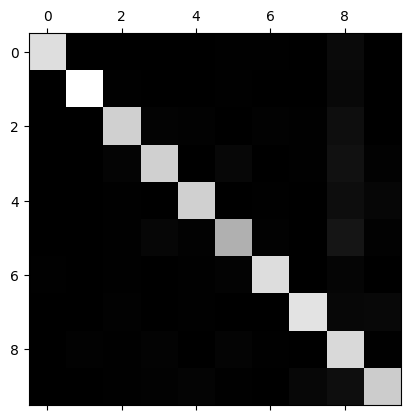

In [44]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18684\119809970.py:1: DeprecationWarning: The asyncore module is deprecated and will be removed in Python 3.12. The recommended replacement is asyncio
  from asyncore import compact_traceback


<function matplotlib.pyplot.show(close=None, block=None)>

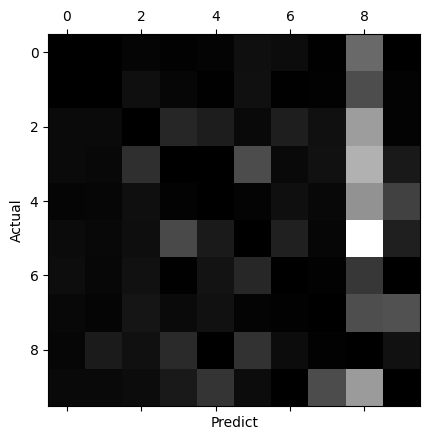

In [45]:
from asyncore import compact_traceback


row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predict")
plt.ylabel("Actual")
plt.show

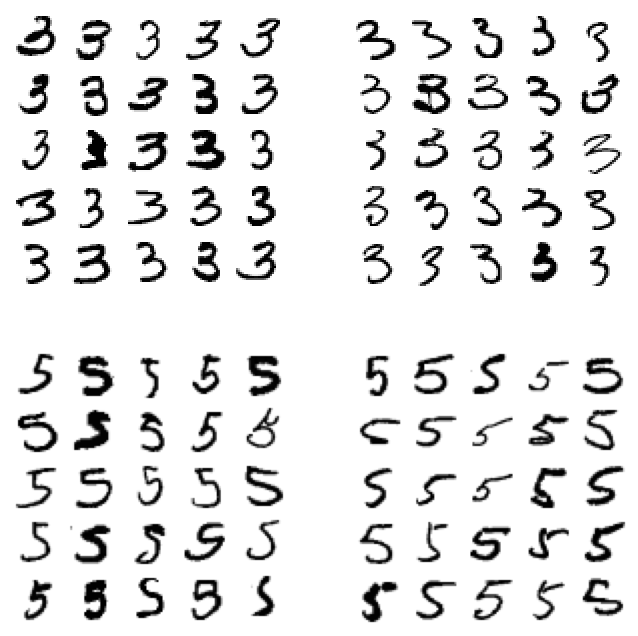

In [46]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

First, let's illustrate a demo

In [47]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

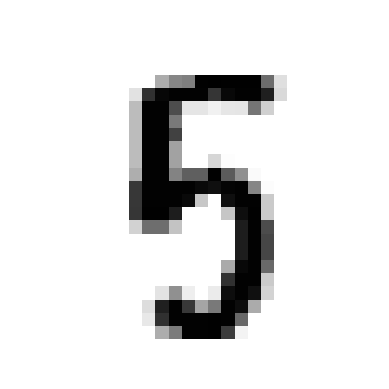

In [48]:
show_image(some_digit)

In [49]:
knn_clf.predict([some_digit])

array([[False,  True]])

## Multioutput Classification

In [50]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

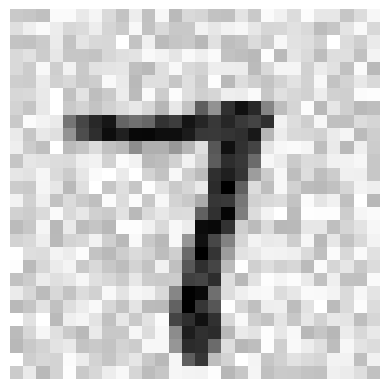

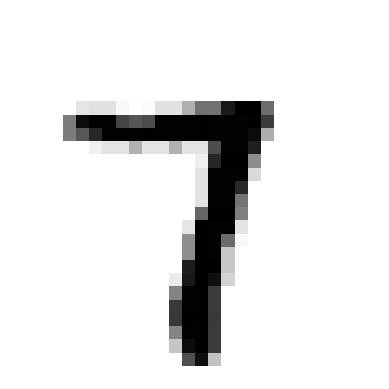

In [51]:
show_image(X_train_mod[36000])
show_image(y_train_mod[36000])

In [52]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

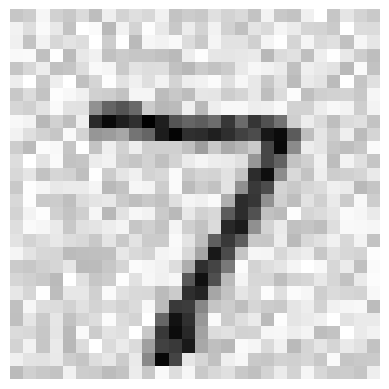

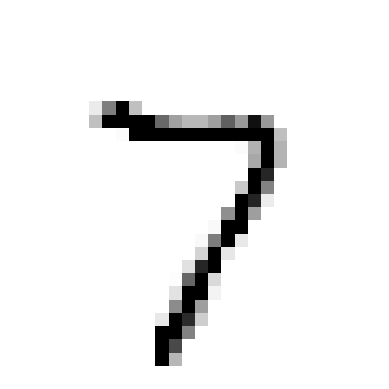

In [53]:
show_image(X_test_mod[0])
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digits(clean_digit)